# Etapa 1: Definición del Problema

**Objetivo:** Se tiene una sabana de datos en formato JSON que se extrae de 
    la información de Mercadolibre productos en venta con  una condición "new" o used" y se debe modelar toda la información para predecir la condición en nuevos datos para productos.

**Buenas prácticas:**
- El problema es de *clasificación*
- Definir la **variable objetivo (condition)** 
- Establecer métricas de evaluación relevantes (ej. Accuracy, F1, RMSE, AUC).
- Validar que existe suficiente información histórica para entrenar el modelo.

# Etapa 2: Adquisición y Entendimiento de Datos

**Objetivo:** Conocer la fuente y la calidad de los datos.

**Buenas prácticas:**
- Reunir datos de distintas fuentes (archivos JSON).
- Hacer un aplanamiento de los datos en columnas (flatten)
- Generar un **data profiling** inicial: 
  - Cantidad de registros y columnas.
  - Tipos de variables (numéricas, categóricas, texto, fechas).
  - Distribuciones estadísticas (media, mediana, desviación).
- Identificar posibles sesgos o desbalances en los datos.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from datetime import timedelta
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from collections import defaultdict
from typing import Any, Dict, List, Union
%matplotlib inline
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = build_dataset()





## Analyzar y mostrar schema de datos cargados y ejemplos de contenido

In [ ]:
columns = list(X_train[0].keys())
print("Columns:", columns)
pd.set_option('display.max_columns', None)
def explore_schema(data, prefix=""):
    """
    Recursively explore schema of a list of dictionaries.
    Supports nested dicts and lists of dicts.
    """
    if not data:
        print("No data available")
        return
    
    # Collect all keys
    all_keys = set().union(*(row.keys() for row in data if isinstance(row, dict)))
    
    for key in all_keys:
        values = [row.get(key) for row in data if key in row]
        non_null_values = [v for v in values if v is not None]
        types = set(type(v) for v in non_null_values)
        
        col_name = f"{prefix}{key}"
        print(f"- {col_name}: {len(non_null_values)} values, types={types}")
        
        # Case 1: Nested dict -> recurse
        if dict in types:
            nested_dicts = [v for v in non_null_values if isinstance(v, dict)]
            if nested_dicts:
                explore_schema(nested_dicts, prefix=">Dictionary:"+col_name + ".")
        
        # Case 2: List -> check contents
        if list in types:
            lists = [v for v in non_null_values if isinstance(v, list)]
            # flatten lists
            flat = []
            for l in lists:
                flat.extend(l)
            
            if flat:  # only recurse if not empty
                inner_types = set(type(x) for x in flat)
                print(f"  ↳ Inside list at {col_name}: element types={inner_types}")
                
                # If list contains dicts, recurse
                dict_elements = [x for x in flat if isinstance(x, dict)]
                if dict_elements:
                    explore_schema(dict_elements, prefix=col_name + "[]:")
print("Schema Summary (X_train):")
explore_schema(X_train)

## Hacer flatten de los datos anidados en cada dictionary/list


In [4]:


def build_dataset():
    """Original dataset loading function"""
    data = [json.loads(x) for x in open("MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def analyze_dataset_structure(data: List[Dict], sample_size: int = 1000):
    """
    Analyze the structure of the dataset and print detailed information about types and columns.
    
    Args:
        data: List of dictionaries (your dataset)
        sample_size: Number of samples to analyze for type inference
    """
    print(f"Dataset Analysis")
    print(f"=" * 50)
    print(f"Total records: {len(data)}")
    print(f"Sample size for analysis: {min(sample_size, len(data))}")
    print(f"Dataset type: {type(data)}")
    print(f"Individual record type: {type(data[0]) if data else 'No data'}")
    print()
    
    # Analyze structure using sample
    sample_data = data[:min(sample_size, len(data))]
    type_info = analyze_nested_structure(sample_data)
    
    print(f"Column Analysis")
    print(f"=" * 50)
    total_columns = len(type_info)
    print(f"Total unique column paths found: {total_columns}")
    print()
    
    # Sort columns by depth and name for better readability
    sorted_columns = sorted(type_info.items(), key=lambda x: (x[0].count('.'), x[0]))
    
    for col_path, info in sorted_columns:
        depth = "  " * col_path.count('.')  # Indent based on nesting depth
        types_str = ", ".join([f"{t.__name__}" for t in info['types']])
        print(f"{depth}{col_path}: {info['count']} values, types={{{types_str}}}")
        
        # Show sample values for leaf nodes (non-dict/list columns)
        if info['sample_values'] and not any(isinstance(v, (dict, list)) for v in info['sample_values']):
            sample_str = str(info['sample_values'][:3])
            if len(sample_str) > 100:
                sample_str = sample_str[:100] + "..."
            print(f"{depth}  Sample values: {sample_str}")
    
    return type_info

def analyze_nested_structure(data: List[Dict]) -> Dict:
    """
    Recursively analyze nested structure and collect type information.
    """
    type_info = defaultdict(lambda: {'types': set(), 'count': 0, 'sample_values': []})
    
    def traverse(obj, path="", parent_is_list=False):
        if isinstance(obj, dict):
            for key, value in obj.items():
                current_path = f"{path}.{key}" if path else key
                
                # Record this key's existence and type
                type_info[current_path]['types'].add(type(value))
                type_info[current_path]['count'] += 1
                if len(type_info[current_path]['sample_values']) < 5:
                    type_info[current_path]['sample_values'].append(value)
                
                # Recursively traverse
                traverse(value, current_path, False)
                
        elif isinstance(obj, list):
            # Record the list itself
            if path:
                type_info[path]['types'].add(list)
                type_info[path]['count'] += 1
            
            # Analyze list elements
            list_element_path = f"{path}[]" if path else "[]"
            for item in obj:
                if item is not None:  # Skip None values
                    type_info[list_element_path]['types'].add(type(item))
                    type_info[list_element_path]['count'] += 1
                    if len(type_info[list_element_path]['sample_values']) < 5:
                        type_info[list_element_path]['sample_values'].append(item)
                    
                    # Recursively traverse list items
                    traverse(item, list_element_path, True)
    
    # Traverse each record in the dataset
    for record in data:
        traverse(record)
    
    return dict(type_info)

def flatten_nested_data(data: List[Dict], max_list_elements: int = 10) -> pd.DataFrame:
    """
    Flatten nested dictionaries and lists into a pandas DataFrame.
    
    Args:
        data: List of nested dictionaries
        max_list_elements: Maximum number of list elements to expand as columns
        
    Returns:
        pandas DataFrame with flattened columns
    """
    flattened_records = []
    
    for record in data:
        flat_record = {}
        flatten_dict(record, flat_record, max_list_elements=max_list_elements)
        flattened_records.append(flat_record)
    
    # Create DataFrame
    df = pd.DataFrame(flattened_records)
    
    print(f"Flattened DataFrame Info:")
    print(f"=" * 30)
    print(f"Shape: {df.shape}")
    print(f"Total columns: {len(df.columns)}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return df

def flatten_dict(obj: Any, result: Dict, prefix: str = "", max_list_elements: int = 10):
    """
    Recursively flatten nested dictionaries and lists.
    """
    if isinstance(obj, dict):
        for key, value in obj.items():
            new_key = f"{prefix}_{key}" if prefix else key
            flatten_dict(value, result, new_key, max_list_elements)
            
    elif isinstance(obj, list):
        # Handle different strategies for lists
        if not obj:  # Empty list
            result[prefix] = None
        elif len(obj) == 1:
            # Single element - flatten directly
            flatten_dict(obj[0], result, prefix, max_list_elements)
        elif all(isinstance(item, (str, int, float, bool)) or item is None for item in obj):
            # List of primitives - convert to string or take statistical measures
            if len(obj) <= max_list_elements:
                for i, item in enumerate(obj):
                    result[f"{prefix}_{i}"] = item
            else:
                # For long lists, create summary statistics
                numeric_items = [x for x in obj if isinstance(x, (int, float))]
                if numeric_items:
                    result[f"{prefix}_mean"] = np.mean(numeric_items)
                    result[f"{prefix}_std"] = np.std(numeric_items)
                    result[f"{prefix}_min"] = np.min(numeric_items)
                    result[f"{prefix}_max"] = np.max(numeric_items)
                result[f"{prefix}_count"] = len(obj)
                result[f"{prefix}_first"] = obj[0] if obj else None
                result[f"{prefix}_last"] = obj[-1] if obj else None
        else:
            # List of complex objects - flatten each with index
            for i, item in enumerate(obj[:max_list_elements]):
                flatten_dict(item, result, f"{prefix}_{i}", max_list_elements)
            
            # If list is longer than max_list_elements, add count
            if len(obj) > max_list_elements:
                result[f"{prefix}_total_count"] = len(obj)
    else:
        # Primitive value
        result[prefix] = obj

def create_feature_matrix(df: pd.DataFrame, target_col: str = None, min_data_threshold: float = 0.4) -> tuple:
    """
    Process the flattened DataFrame for machine learning.
    Filters columns based on data completeness and returns only useful features.
    
    Args:
        df: Flattened DataFrame
        target_col: Name of target column
        min_data_threshold: Minimum percentage of valid data required (default: 0.4 = 40%)
        
    Returns:
        Tuple of (X, y, feature_info)
    """
    print(f"Data Completeness Analysis:")
    print(f"=" * 40)
    print(f"Minimum data threshold: {min_data_threshold*100}%")
    print(f"Original DataFrame shape: {df.shape}")
    print()
    
    # Calculate data completeness for each column
    completeness_stats = []
    
    for col in df.columns:
        if col == target_col:
            continue
            
        # Count valid data (not null, not NaN, not empty)
        valid_count = 0
        total_count = len(df)
        
        for value in df[col]:
            if pd.notna(value):  # Not NaN/None
                if isinstance(value, str):
                    if value.strip() != '':  # Not empty string
                        valid_count += 1
                elif isinstance(value, (list, dict)):
                    if len(value) > 0:  # Not empty list/dict
                        valid_count += 1
                else:
                    valid_count += 1  # Valid numeric or boolean
        
        valid_percentage = valid_count / total_count if total_count > 0 else 0
        
        completeness_stats.append({
            'column': col,
            'valid_count': valid_count,
            'total_count': total_count,
            'valid_percentage': valid_percentage,
            'dtype': str(df[col].dtype)
        })
    
    # Sort by completeness percentage (descending)
    completeness_stats.sort(key=lambda x: x['valid_percentage'], reverse=True)
    print(f"{'Column':<40} {'Valid%':<8} {'Valid/Total':<15} {'Data Type':<15}")
    print("-" * 80)
    
    columns_above_threshold = []
    columns_below_threshold = []
    
    for stat in completeness_stats:
        col = stat['column']
        valid_pct = stat['valid_percentage']
        valid_count = stat['valid_count']
        total_count = stat['total_count']
        dtype = stat['dtype']
        
        # Truncate long column names for display
        display_col = col[:37] + "..." if len(col) > 40 else col
        print(f"{display_col:<40} {valid_pct*100:>6.1f}% {valid_count:>6}/{total_count:<6} {dtype:<15}")
        
        if valid_pct >= min_data_threshold:
            columns_above_threshold.append(col)
        else:
            columns_below_threshold.append(col)
    
    print()
    print(f"Summary:")
    print(f"Columns above {min_data_threshold*100}% threshold: {len(columns_above_threshold)}")
    print(f"Columns below {min_data_threshold*100}% threshold: {len(columns_below_threshold)}")
    print()
    
    # Filter DataFrame to keep only columns with sufficient data
    filtered_columns = columns_above_threshold
    processed_df = df[filtered_columns].copy()
    
    # Separate target if specified
    y = None
    if target_col and target_col in df.columns:
        y = df[target_col]
    
    # Analyze feature types for remaining columns
    numeric_cols = []
    categorical_cols = []
    text_cols = []
    
    for col in processed_df.columns:
        if processed_df[col].dtype in ['int64', 'float64']:
            numeric_cols.append(col)
        elif processed_df[col].dtype == 'object':
            # Check if it's categorical or text
            unique_ratio = processed_df[col].nunique() / len(processed_df)
            avg_length = processed_df[col].astype(str).str.len().mean()
            
            if unique_ratio < 0.1 or avg_length < 20:  # Likely categorical
                categorical_cols.append(col)
            else:
                text_cols.append(col)
        else:  # boolean, datetime, etc.
            categorical_cols.append(col)
    
    feature_info = {
        'numeric_columns': numeric_cols,
        'categorical_columns': categorical_cols,
        'text_columns': text_cols,
        'total_features': len(processed_df.columns),
        'original_features': len(df.columns) - (1 if target_col else 0),
        'filtered_features': len(processed_df.columns),
        'removed_features': len(columns_below_threshold),
        'completeness_stats': completeness_stats,
        'columns_removed': columns_below_threshold,
        'min_threshold_used': min_data_threshold
    }
    
    print(f"Final Feature Analysis:")
    print(f"=" * 25)
    print(f"Original features: {feature_info['original_features']}")
    print(f"Filtered features: {feature_info['filtered_features']}")
    print(f"Removed features: {feature_info['removed_features']}")
    print(f"Reduction: {(feature_info['removed_features']/feature_info['original_features']*100):.1f}%")
    print()
    print(f"Feature type breakdown:")
    print(f"  Numeric features: {len(numeric_cols)}")
    print(f"  Categorical features: {len(categorical_cols)}")
    print(f"  Text features: {len(text_cols)}")
    print(f"Final DataFrame shape: {processed_df.shape}")
    
    # Show some examples of removed columns
    if columns_below_threshold:
        print(f"\nExample removed columns (low data completeness):")
        for col in columns_below_threshold[:10]:
            completeness = next(s['valid_percentage'] for s in completeness_stats if s['column'] == col)
            print(f"  {col}: {completeness*100:.1f}% complete")
        if len(columns_below_threshold) > 10:
            print(f"  ... and {len(columns_below_threshold) - 10} more")
    
    return processed_df, y, feature_info

def flatten_feature_matrix(X_train,y_train,min_data_threshold=0.1):

    #X_train, y_train, X_test, y_test = build_dataset()
    
    print("STEP 1: Dataset Type Analysis")
    print("=" * 60)
    type_info = analyze_dataset_structure(X_train, sample_size=1000)
    
    print("\n" + "="*60)
    print("STEP 2: Flattening Dataset")
    print("=" * 60)
    
    # Flatten the training data
    df_train = flatten_nested_data(X_train, max_list_elements=5)
    
    # Add target variable
    df_train['condition'] = y_train
    
    print(f"\nFirst few rows of flattened data:")
    print(df_train.head())
    
    print(f"\nColumn names (first 20):")
    print(list(df_train.columns[:20]))
    
    print("\n" + "="*60)
    print("STEP 3: Feature Matrix Creation")
    print("=" * 60)
    
    # Create feature matrix with data completeness filtering
    X, y, feature_info = create_feature_matrix(df_train, target_col='condition', min_data_threshold=0.1)
    
    print(f"\nTarget distribution:")
    if y is not None:
        print(y.value_counts())
        print(f"Target completeness: {(y.notna().sum() / len(y) * 100):.1f}%")
    
    print(f"\nFinal X matrix info:")
    print(f"Shape: {X.shape}")
    print(f"Memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Show sample of remaining columns
    print(f"\nSample of final feature columns:")
    for i, col in enumerate(X.columns[:15]):
        print(f"  {i+1:2d}. {col}")
    if len(X.columns) > 15:
        print(f"  ... and {len(X.columns) - 15} more columns")
    return X,y,feature_info

In [5]:
X,y,feature_info = flatten_feature_matrix(X_train,y_train,min_data_threshold=0.2)

STEP 1: Dataset Type Analysis
Dataset Analysis
Total records: 90000
Sample size for analysis: 1000
Dataset type: <class 'list'>
Individual record type: <class 'dict'>

Column Analysis
Total unique column paths found: 150

accepts_mercadopago: 1000 values, types={bool}
  Sample values: [True, True, True]
attributes: 2000 values, types={list}
attributes[]: 806 values, types={dict}
automatic_relist: 1000 values, types={bool}
  Sample values: [False, False, False]
available_quantity: 1000 values, types={int}
  Sample values: [1, 1, 1]
base_price: 1000 values, types={float, int}
  Sample values: [80, 2650, 60]
buying_mode: 1000 values, types={str}
  Sample values: ['buy_it_now', 'buy_it_now', 'buy_it_now']
catalog_product_id: 1000 values, types={NoneType}
  Sample values: [None, None, None]
category_id: 1000 values, types={str}
  Sample values: ['MLA126406', 'MLA10267', 'MLA1227']
condition: 1000 values, types={str}
  Sample values: ['new', 'used', 'used']
coverage_areas: 2000 values, types

In [ ]:

numeric_columns = feature_info['numeric_columns']
#numeric_columns.remove("seller_id")
# --- Parte 1: Estadísticas Descriptivas (esto siempre es rápido) ---
print(" Estadísticas Descriptivas de las Variables Numéricas:")
print(X[numeric_columns].describe().transpose())
print("\n" + "="*80 + "\n")

print(" Generando Histogramas de Distribución ...")

# Define el número de columnas para la cuadrícula
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

# Crea la figura y los ejes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Itera y crea un histograma para cada columna
for i, col in enumerate(numeric_columns):
    ax = axes[i]
    if pd.api.types.is_numeric_dtype(X[col]):
        # Usa el método .hist() de pandas, que es un wrapper rápido de matplotlib
        X[col].hist(ax=ax, bins=40)
        ax.set_title(f'Distribución de {col}')
    else:
        # Si una columna en la lista no es numérica, lo indica y la salta
        ax.text(0.5, 0.5, f'"{col}"\nno es numérica', ha='center', va='center')
        ax.set_title(f'Distribución de {col}', color='red')

# Oculta los ejes sobrantes
for j in range(len(numeric_columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [27]:
def histograma(df, col, bins=50):
    """
    Genera histogramas para una variable:
    - Versión normal (lineal)
    - Versión con escala logarítmica (si aplica)
    """
    data = df[col].dropna()
    low, high = np.percentile(data, [1, 99])
    data = data[(data >= low) & (data <= high)]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Histograma normal ---
    axes[0].hist(data, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Histograma de {col} (lineal)')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")

    # --- Histograma logarítmico ---
    # Solo tiene sentido si los valores son positivos
    if (data > 0).all():
        axes[1].hist(data, bins=bins, color='salmon', edgecolor='black', alpha=0.7)
        axes[1].set_xscale("log")
        axes[1].set_title(f'Histograma de {col} (escala log)')
        axes[1].set_xlabel(col)
        axes[1].set_ylabel("Frecuencia")
    else:
        axes[1].text(0.5, 0.5, "No se puede usar log (valores <= 0)",
                     ha="center", va="center")
        axes[1].set_title(f'{col} (escala log)')

    plt.tight_layout()
    plt.show()
def boxplot(df, col,out=0):
    """
    Genera un boxplot para una variable,
    mostrando outliers sin eliminarlos.
    """
    data = df[col].dropna()
    if out==1:
        low, high = np.percentile(data, [1, 99])
        data = data[(data >= low) & (data <= high)]
    plt.figure(figsize=(8, 5))
    plt.boxplot(data, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='o', color='black', alpha=0.5))
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

In [ ]:
histograma(X,"price")
boxplot(X,"price",0)
boxplot(X,"price",1)

In [ ]:
histograma(X,"sold_quantity")
boxplot(X,"sold_quantity",0)
histograma(X,"available_quantity")
boxplot(X,"available_quantity",0)
histograma(X,"initial_quantity")
boxplot(X,"initial_quantity",0)

## Analisis de las variables mas importantes para predecir vs "condition"

In [ ]:
# Por ser incluido en tiempo adicional

### Hacer profiling del X_train dataset sin depurar ni extraer variables con poca data o muchos nulos

In [ ]:
!pip install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport

# Example: load a dataset
df_p = pd.DataFrame(df_train)

# Create the profiling report
profile = ProfileReport(
    df_p,
    title="Dataset Profiling Report",
    explorative=True,   # richer analysis
    minimal=False       # set True for faster/simpler report
)

# Save to HTML file
profile.to_file("profiling_report.html")

# Or display inline in Jupyter
profile.to_notebook_iframe()

# Etapa 3: Limpieza y Preparación de Datos

**Objetivo:** Garantizar calidad y consistencia en los datos para modelar.

**Subetapas y prácticas:**
- **Manejo de valores faltantes:** imputación con media, mediana, moda o modelos.
- **Detección de outliers:** métodos estadísticos o de clustering.
- **Normalización de formatos:** unificación de tipos de datos (fechas, texto).
- **Codificación de variables categóricas:** One-Hot Encoding, Label Encoding.
- **Balanceo de clases (si es clasificación):** SMOTE, undersampling, oversampling. (no necesario por el primer analisis de balanceo en **condition**)

In [13]:
# ==============================================================================
# VALIDACIÓN DE BALANCEO DE CLASES - VARIABLE "CONDITION"
# ==============================================================================


print("ANÁLISIS DE BALANCEO DE CLASES - VARIABLE CONDITION")

print("\n1. DISTRIBUCIÓN DE CLASES:")

# Contar valores de cada clase
class_counts = y_original.value_counts()
print(f"\nConteo por clase:")
print(class_counts)

# Calcular porcentajes
class_percentages = y_original.value_counts(normalize=True) * 100
print(f"\nPorcentaje por clase:")
for clase, porcentaje in class_percentages.items():
    print(f"  {clase}: {porcentaje:.2f}%")

print("\n2. ANÁLISIS DE BALANCE:")
ratio = class_counts.min() / class_counts.max()
print(f"\nRatio minoritaria/mayoritaria: {ratio:.2f}")

# Diferencia absoluta entre clases
diferencia = abs(class_percentages.iloc[0] - class_percentages.iloc[1])
print(f"Diferencia absoluta entre clases: {diferencia:.2f}%")

print("\n3. EVALUACIÓN DE BALANCE:")

umbral_severo = 0.1   
umbral_moderado = 0.3   
umbral_leve = 0.4     

if ratio >= umbral_leve:
    estado = "BALANCEADO"
    color = "green"
    recomendacion = "NO se requiere técnica de balanceo"
elif ratio >= umbral_moderado:
    estado = "DESBALANCEO LEVE"
    color = "yellow"
    recomendacion = "Opcional: considerar weighted classes"
elif ratio >= umbral_severo:
    estado = "DESBALANCEO MODERADO"
    color = "orange"
    recomendacion = "Recomendado: usar class_weight o sampling"
else:
    estado = "DESBALANCEO SEVERO"
    color = "red"
    recomendacion = "Necesario: SMOTE, undersampling o ensemble"

print(f"\nEstado del dataset: {estado}")
print(f"Recomendación: {recomendacion}")

ANÁLISIS DE BALANCEO DE CLASES - VARIABLE CONDITION

1. DISTRIBUCIÓN DE CLASES:

Conteo por clase:
condition
new     48352
used    41648
Name: count, dtype: int64

Porcentaje por clase:
  new: 53.72%
  used: 46.28%

2. ANÁLISIS DE BALANCE:

Ratio minoritaria/mayoritaria: 0.86
Diferencia absoluta entre clases: 7.45%

3. EVALUACIÓN DE BALANCE:

Estado del dataset: BALANCEADO
Recomendación: NO se requiere técnica de balanceo


# Etapa 4: Selección de Características (Feature Selection)

**Objetivo:** Elegir las variables más relevantes para mejorar rendimiento y evitar sobreajuste.

**Buenas prácticas:**
- **Análisis de completitud:** eliminar variables con demasiados nulos.
- **Análisis estadístico:** correlaciones, ANOVA, pruebas de chi-cuadrado.
- **Reducción de dimensionalidad:** PCA y otros no aplicados aun para experimentar despues
- **Importancia de variables:** basada en árboles de decisión, Random Forest
- Evitar multicolinealidad (variables muy correlacionadas entre sí).

In [ ]:

warnings.filterwarnings('ignore')

# ==============================================================================
# FASE 0:  CONFIGURACIÓN INICIAL
# ==============================================================================


def feature_engineering_dates(df, feature_info):
    """
    Crea nuevas características a partir de las columnas de fecha.
    """
    print(" INGENIERÍA DE CARACTERÍSTICAS: Fechas ".center(80, '-'))
#    df['publication_days'] = (df['last_updated'] - df['date_created']).dt.days
#    feature_info['date_columns'].append(['date_created', 'last_updated','start_time','stop_time'])

    # Actualizar feature_info
#    feature_info['numeric_columns'].append('publication_days')
    
    # Descartar columnas originales de fecha
#    df.drop(columns=feature_info['date_columns'], inplace=True)
    cdates = ['date_created', 'last_updated', 'start_time', 'stop_time']
#    print(df["date_created"][:5])
#    df.drop(columns=cdates, inplace=True)
#    print("Nueva columna creada: 'publication_days'.")
#    print("Columnas de fecha originales eliminadas.")
    print("-" * 80)
    return df, feature_info

# ==============================================================================
# FASE 1: PREPROCESAMIENTO Y FILTRADO INICIAL
# ==============================================================================

def filter_low_variance(df, feature_info, threshold=0.01):
    """
    Elimina características numéricas con varianza por debajo de un umbral.
    """
    print(" FASE 1.1: Filtrando por baja varianza ".center(80, '='))
    initial_cols = df.shape[1]
    numeric_cols = feature_info['numeric_columns']
    print("Numerical:", numeric_cols)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df[numeric_cols])
    
    cols_to_keep = df.columns[selector.get_support(indices=True)]
    cols_to_remove = set(numeric_cols) - set(cols_to_keep)
    
    df_filtered = df.drop(columns=cols_to_remove)
    feature_info['numeric_columns'] = [col for col in numeric_cols if col not in cols_to_remove]
    
    print(f"Columnas antes del filtro: {initial_cols}")
    print(f"Columnas después del filtro: {df_filtered.shape[1]}")
    print(f"Se eliminaron {len(cols_to_remove)} columnas numéricas por tener varianza < {threshold}: {list(cols_to_remove)}")
    print("-" * 80)
    return df_filtered, feature_info

def filter_high_correlation(df, feature_info, threshold=0.90):
    """
    Elimina una de cada par de características numéricas con alta correlación.
    """
    print(" FASE 1.2: Filtrando por alta correlación ".center(80, '='))
    initial_cols = df.shape[1]
    numeric_cols = feature_info['numeric_columns']
    
    corr_matrix = df[numeric_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    cols_to_remove = [column for column in upper.columns if any(upper[column] > threshold)]
    
    df_filtered = df.drop(columns=cols_to_remove)
    feature_info['numeric_columns'] = [col for col in numeric_cols if col not in cols_to_remove]
    
    print(f"Columnas antes del filtro: {initial_cols}")
    print(f"Columnas después del filtro: {df_filtered.shape[1]}")
    print(f"Se eliminaron {len(cols_to_remove)} columnas por tener correlación > {threshold}: {cols_to_remove}")
    print("-" * 80)
    return df_filtered, feature_info

# ==============================================================================
# FASE 2: SELECCIÓN BASADA EN ESTADÍSTICAS
# ==============================================================================

def select_features_statistically(df, y, feature_info, k_numeric=100, k_categorical=50):
    """
    Selecciona las mejores K características numéricas y categóricas usando tests estadísticos.
    """
    print(" FASE 2: Selección de características con tests estadísticos ".center(80, '='))
    
    # --- Selección Numérica con ANOVA F-test ---
    print("\n--- Analizando características NUMÉRICAS con ANOVA F-test ---")
    numeric_cols = feature_info['numeric_columns']
    selector_num = SelectKBest(f_classif, k=min(k_numeric, len(numeric_cols)))
    selector_num.fit(df[numeric_cols].fillna(0), y)
    selected_numeric = [numeric_cols[i] for i in selector_num.get_support(indices=True)]
    print(f"De {len(numeric_cols)} características numéricas, se seleccionaron las {len(selected_numeric)} mejores.")
    
    # --- Selección Categórica con Chi-Cuadrado ---
    print("\n--- Analizando características CATEGÓRICAS con Chi-Cuadrado ---")
    categorical_cols = feature_info['categorical_columns']
    
    # Para Chi2, necesitamos convertir categorías a números y manejar nulos
    df_cat_encoded = pd.DataFrame()
    for col in categorical_cols:
        df_cat_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))
        
    selector_cat = SelectKBest(chi2, k=min(k_categorical, len(categorical_cols)))
    selector_cat.fit(df_cat_encoded, y)
    selected_categorical = [categorical_cols[i] for i in selector_cat.get_support(indices=True)]
    print(f"De {len(categorical_cols)} características categóricas, se seleccionaron las {len(selected_categorical)} mejores.")
    
    final_selected_cols = selected_numeric + selected_categorical + feature_info['text_columns']
    
    print(f"\nTotal de características pre-seleccionadas (num + cat + text): {len(final_selected_cols)}")
    print("-" * 80)
    return df[final_selected_cols], selected_numeric, selected_categorical

# ==============================================================================
# FASE 3: SELECCIÓN de FEATURES BASADA EN MODELO ( CON RANDOM FOREST)
# ==============================================================================

def select_features_with_model(df, y, numeric_cols, categorical_cols, text_cols, top_n=100):
    """
    Usa RandomForest para encontrar las características más importantes, incluyendo el texto.
    """
    print(" FASE 3: Selección final de características con RandomForest ".center(80, '='))
    
    # --- Procesamiento de Texto con TF-IDF (sin cambios) ---
    print("\n--- Vectorizando columna 'title' con TF-IDF ---")
    #tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
    #text_features = tfidf.fit_transform(df[text_cols[0]])
    #print(f"La columna '{text_cols[0]}' se convirtió en una matriz de {text_features.shape[1]} características.")
    
    # --- Preparar y Combinar el resto de características (sin cambios) ---
    numeric_features = df[numeric_cols].fillna(0).values
    
    categorical_features_encoded = []
    for col in categorical_cols:
        encoded_col = LabelEncoder().fit_transform(df[col].astype(str)).reshape(-1, 1)
        categorical_features_encoded.append(encoded_col)
    
    if categorical_features_encoded:
        categorical_features = np.hstack(categorical_features_encoded)
    else:
        categorical_features = np.array([[] for _ in range(len(df))])

#    #X_combined = hstack([numeric_features, categorical_features, text_features]).tocsr()
    X_combined = np.hstack([numeric_features, categorical_features]) 

    feature_names = numeric_cols + categorical_cols ########+ tfidf.get_feature_names_out().tolist()

    print(f"\nTotal de características para alimentar el modelo: {X_combined.shape[1]}")
    
    # --- Entrenar RandomForest para obtener importancia ---
    print("Entrenando RandomForest para calcular la importancia de cada característica...")

    model = RandomForestClassifier(random_state=42, n_jobs=-1) 
    model.fit(X_combined, y)
    
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Seleccionar las N mejores
    final_features = importances.head(top_n)['feature'].tolist()
    
    print(f"\nLas {top_n} características más importantes según el modelo son:")
    print(importances.head(15))
    
    print(f"\nTotal de características finales seleccionadas: {len(final_features)}")
    print("=" * 80)
    return final_features

# ==============================================================================
# EJECUCIÓN DEL PIPELINE
# ==============================================================================

start_time = time.time()

X__train = pd.DataFrame(X)
X__train, feature__info = feature_engineering_dates(X__train, feature_info)

# Fase 1: Filtros iniciales
#   X__train, feature__info = filter_low_variance(X__train, feature__info, threshold=0.01)
#   X__train, feature__info = filter_high_correlation(X__train, feature__info, threshold=0.9)

# Fase 2: Selección estadística
X_stat_selected, numeric_selected, cat_selected = select_features_statistically(
    X__train, 
    y_train, 
    feature__info, 
    k_numeric=50, 
    k_categorical=100
)

# Fase 3: Selección final con modelo
final_feature_list = select_features_with_model(
    X_stat_selected, 
    y_train, 
    numeric_cols=numeric_selected,
    categorical_cols=cat_selected,
    text_cols=feature__info['text_columns'],
    top_n=75  # Pedimos las 75 características finales más potentes
)

end_time = time.time()
total_time = str(timedelta(seconds=end_time - start_time))

print("\n" + " PROCESO DE SELECCIÓN DE CARACTERÍSTICAS COMPLETADO ")
print(f"Partiendo de {len(X.columns) } columnas originales, hemos seleccionado las {len(final_feature_list)} más predictivas.")
print(f"Tiempo total de ejecución: {total_time}")
print("\nLista final de características recomendadas para entrenar el modelo:")
print(final_feature_list)

-------------------- INGENIERÍA DE CARACTERÍSTICAS: Fechas ---------------------
--------------------------------------------------------------------------------
========= FASE 2: Selección de características con tests estadísticos ==========

--- Analizando características NUMÉRICAS con ANOVA F-test ---
De 7 características numéricas, se seleccionaron las 7 mejores.

--- Analizando características CATEGÓRICAS con Chi-Cuadrado ---
De 72 características categóricas, se seleccionaron las 72 mejores.

Total de características pre-seleccionadas (num + cat + text): 99
--------------------------------------------------------------------------------
========= FASE 3: Selección final de características con RandomForest ==========

--- Vectorizando columna 'title' con TF-IDF ---

Total de características para alimentar el modelo: 79
Entrenando RandomForest para calcular la importancia de cada característica...

Las 75 características más importantes según el modelo son:
                     fea

# Etapa 5: Entrenamiento y Validación

**Objetivo:** Ajustar los modelos y compararlos.

**Buenas prácticas:**
- Usar **validación cruzada (k-fold)** para evaluar estabilidad.
- Ajustar hiperparámetros con **GridSearchCV** o **RandomizedSearchCV**. (TBD)
- Guardar métricas de entrenamiento y validación para detectar *overfitting*.

In [ ]:

# ==============================================================================
# 1. PREPARACIÓN DE DATOS
# ==============================================================================
print("--- 1. Preparando los datos ---")
y_original = y.copy()  # Variable objetivo original (texto)
X_final_features = X[final_feature_list]  # Selección final de características
# a. Codificar la variable objetivo 'y' de texto a números (0 y 1)
le = LabelEncoder()
y_final = le.fit_transform(y_original)

y_original = y  # Variable objetivo original (texto)
X_final_features = X[final_feature_list]  # Selección final de características

# Encode target variable
#class_mapping = {'new': 0, 'used': 1}
#class_labels = list(class_mapping.keys())
#y = y_original.map(class_mapping)
# b. Dividir los datos en entrenamiento y prueba (80% / 20%)

X_train, X_test, y_train, y_test = train_test_split(
    X_final_features, y_final, test_size=0.2, random_state=42, stratify=y
)
print(f"Datos divididos en {X_train.shape[0]} para entrenamiento y {X_test.shape[0]} para prueba.")
print("-" * 60)
# ==============================================================================
# 1.5. ROBUST FIX: UNIFY CATEGORICAL COLUMN TYPES 
# ==============================================================================
print("--- 1.5. Forzando la unificación de tipos en columnas categóricas ---")

# a. Identify categorical columns from your training data
categorical_features_to_fix = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Se unificará el tipo de dato a 'string' para las {len(categorical_features_to_fix)} columnas categóricas.")

# b. Convert every categorical column to string type in BOTH dataframes
# This is the key step to ensure uniformity.
for col in categorical_features_to_fix:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("¡Tipos de datos unificados exitosamente!")
print("-" * 60)


# ==============================================================================
# 2. DEFINIR EL PIPELINE DE PREPROCESAMIENTO
# ==============================================================================
print("--- 2. Definiendo el pipeline de preprocesamiento ---")

# a. Identificar columnas numéricas y categóricas
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Detectadas {len(numeric_features)} características numéricas.")
print(f"Detectadas {len(categorical_features)} características categóricas.")

# b. Crear los transformadores para cada tipo de dato

#    Paso 1: Imputar (rellenar) los valores NaN con la media de la columna.
#    Paso 2: Estandarizar los valores.
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# Para categóricas: One-Hot Encoding (sin cambios)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# c. Unir los transformadores con ColumnTransformer (sin cambios)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("ColumnTransformer creado exitosamente (con imputer para NaNs).")
print("-" * 60)

# ==============================================================================
# 3. CONSTRUIR Y ENTRENAR EL PIPELINE COMPLETO
# ==============================================================================
print("--- 3. Construyendo y entrenando el pipeline completo ---")

# Unimos el preprocesador y el modelo en un solo objeto.

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Entrenar el pipeline completo con los datos de entrenamiento
pipeline.fit(X_train, y_train)

print("¡Pipeline entrenado exitosamente!")
print("-" * 60)


# ==============================================================================
# 4. EVALUAR EL MODELO
# ==============================================================================
print("--- 4. Evaluando el modelo con los datos de prueba ---")

# a. Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probabilidades para la clase '1'

# b. Métricas de evaluación
# Accuracy: ¿Qué porcentaje de predicciones fueron correctas en general?
accuracy = accuracy_score(y_test, y_pred)
print(f" Exactitud (Accuracy): {accuracy:.4f}\n")

# Matriz de Confusión: ¿Cómo se equivocó el modelo?
# Muestra Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos.
print(" Matriz de Confusión:")

cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=le.classes_, columns=["new", "used"]))
print("\n")

# Reporte de Clasificación: Métricas detalladas por clase.
# - Precision: De los que predijimos como 'new', ¿cuántos acertamos?
# - Recall: De todos los que eran realmente 'new', ¿cuántos encontramos?
print(" Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["new", "used"]))
print("\n")

# ROC AUC Score: ¿Qué tan bueno es el modelo para distinguir entre las dos clases?
# Un valor de 1.0 es perfecto, 0.5 es como adivinar al azar.
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f" ROC AUC Score: {roc_auc:.4f}")

# Visualizar la curva ROC
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('Curva ROC')
plt.show()


# Etapa 7: Selección de Modelos, comparando con otros modelos y validar que no haya overfitting

**Objetivo:** Escoger algoritmos adecuados para el problema.

**Buenas prácticas:**
- Probar una familia diversa de modelos: regresión logística, SVM, árboles de decisión, Random Forest, Gradient Boosting, Redes Neuronales (TBD)
- Incluir **baselines simples** 
- Considerar interpretabilidad vs. performance según el caso de negocio.

--- Limpiando tipos de datos en los sets completos ---
¡Limpieza completada!
Tamaño del set de entrenamiento: 54000
Tamaño del set de validación: 18000
Tamaño del set de prueba: 18000
------------------------------------------------------------
--- 2. Realizando Cross-Validation para Random Forest ---
Puntajes ROC AUC de Cross-Validation: [0.9514 0.9529 0.9522 0.9501 0.9535]
Promedio de ROC AUC en CV: 0.9520 (+/- 0.0012)
Un promedio alto con una desviación estándar baja sugiere que el modelo es estable.
------------------------------------------------------------
--- 3. Entrenando y Comparando Modelos ---
Entrenando RandomForest...
Entrenando Logistic Regression...
¡Modelos entrenados!
------------------------------------------------------------
--- 4. Evaluación Final en el Set de Prueba ---

### Reporte de Clasificación - RandomForest ###
              precision    recall  f1-score   support

         new       0.91      0.87      0.89      9670
        used       0.85      0.90     

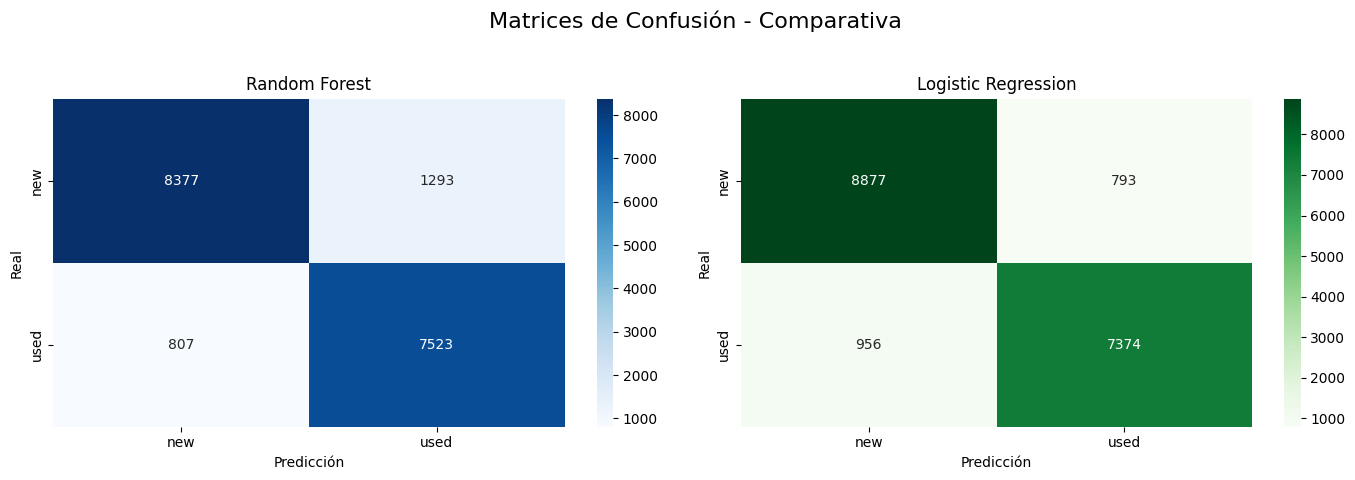

ROC AUC Score (Random Forest): 0.9538
ROC AUC Score (Logistic Regression): 0.9633


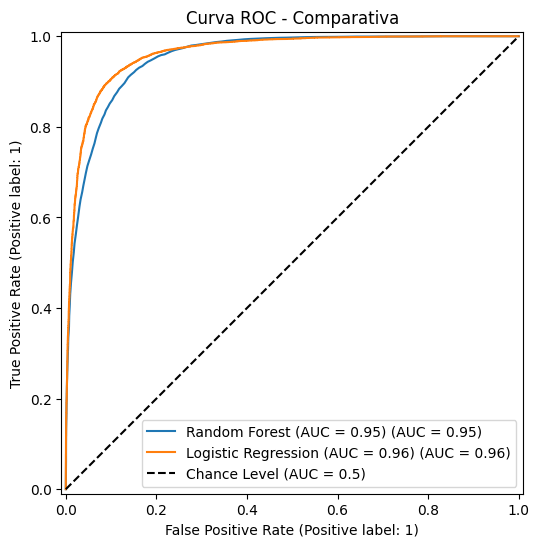

In [ ]:


# ==============================================================================
# 0. DATA PREPARATION (Assuming X_final_features and y_original are loaded)
# ==============================================================================
y_original = y.copy()  # Variable objetivo original (texto)
X_final_features = X[final_feature_list]  # Selección final de características
# a. Codificar la variable objetivo 'y' de texto a números (0 y 1)
le = LabelEncoder()
y_final = le.fit_transform(y_original)

y_original = y  # Variable objetivo original (texto)
X_final_features = X[final_feature_list]  # Selección final de características
class_labels = ["new","used"]
# Encode target variable
#class_mapping = {'new': 0, 'used': 1}
#class_labels = list(class_mapping.keys())
#y = y_original.map(class_mapping)
# b. Dividir los datos en entrenamiento y prueba (80% / 20%)

X_train, X_test, y_train, y_test = train_test_split(
    X_final_features, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print("--- Limpiando tipos de datos en los sets completos ---")
# Identifica las columnas categóricas desde el set de entrenamiento completo
categorical_features_to_fix = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_features_to_fix:
    # Aplica la conversión a string en los sets que se usarán
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("¡Limpieza completada!")
# --------------------------------------------------------------------------------

# Ahora, crea el set de validación a partir de los datos YA LIMPIOS
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del set de validación: {X_val.shape[0]}")
print(f"Tamaño del set de prueba: {X_test.shape[0]}")



# ==============================================================================
# 1. PREPROCESSING PIPELINE 
# ==============================================================================
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert all categorical columns to string to avoid mixed type errors
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


# ==============================================================================
# 2. CROSS-VALIDATION (Checking for Overfitting)
# ==============================================================================
print("--- 2. Realizando Cross-Validation para Random Forest ---")

# Create the full pipeline with the RandomForest model
rf_pipeline = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))

# Perform 5-fold cross-validation on the FULL training dataset
# We use X_train_full to get a more robust estimate
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Puntajes ROC AUC de Cross-Validation: {np.round(cv_scores, 4)}")
print(f"Promedio de ROC AUC en CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("Un promedio alto con una desviación estándar baja sugiere que el modelo es estable.")
print("-" * 60)


# ==============================================================================
# 3. MODEL TRAINING AND COMPARISON
# ==============================================================================
print("--- 3. Entrenando y Comparando Modelos ---")

# a. Define the models to compare

lr_pipeline = make_pipeline(preprocessor, LogisticRegression(random_state=42, max_iter=1000))

# b. Train both models on the (smaller) training set
print("Entrenando RandomForest...")
rf_pipeline.fit(X_train, y_train)

print("Entrenando Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

print("¡Modelos entrenados!")
print("-" * 60)


# ==============================================================================
# 4. EVALUATION ON THE TEST SET
# ==============================================================================
print("--- 4. Evaluación Final en el Set de Prueba ---")

# Get predictions for both models
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_lr = lr_pipeline.predict(X_test)

# --- Classification Reports ---
print("\n### Reporte de Clasificación - RandomForest ###")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))

print("\n### Reporte de Clasificación - Logistic Regression ###")
print(classification_report(y_test, y_pred_lr, target_names=class_labels))


# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión - Comparativa', fontsize=16)

# RandomForest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_title('Random Forest')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- ROC Curves ---
# Get prediction probabilities
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Calculate AUC scores
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"ROC AUC Score (Random Forest): {roc_auc_rf:.4f}")
print(f"ROC AUC Score (Logistic Regression): {roc_auc_lr:.4f}")

# Plotting the curves
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name=f'Random Forest (AUC = {roc_auc_rf:.2f})', ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
ax.set_title('Curva ROC - Comparativa')
ax.legend()
plt.show()

# Etapa 8 : Flujo de experimentación y analisis completo de metricas con MLFLOW

2025/08/29 10:22:27 INFO mlflow.tracking.fluent: Experiment with name 'Prediccion_New_vs_Used' does not exist. Creating a new experiment.


 MLflow - Experimento: 'Prediccion_New_vs_Used'

--- Limpiando tipos de datos en los sets completos ---
¡Limpieza completada!
Tamaño del set de entrenamiento: 54000
Tamaño del set de validación: 18000
Tamaño del set de prueba: 18000


--- 2. Realizando Cross-Validation para Random Forest con MLflow ---
Puntajes ROC AUC de Cross-Validation: [0.9514 0.9529 0.9522 0.9501 0.9535]
Promedio de ROC AUC en CV: 0.9520192938455283 (+/- 0.001203862090867785)
 Métricas de CV guardadas en MLflow
--- 3. Entrenando y Comparando Modelos con MLflow ---

 Entrenando RandomForest con MLflow...


2025/08/29 10:31:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/29 10:31:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Random Forest - Test ROC AUC: 0.9537911338268502
   Accuracy: 0.8833333333333333 | Precision: 0.8533348457350273 | Recall: 0.9031212484993998

 Entrenando Logistic Regression con MLflow...


2025/08/29 10:31:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/29 10:31:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Logistic Regression - Test ROC AUC: 0.9633904192493957
   Accuracy: 0.9034444444444445 | Precision: 0.9036247856967916 | Recall: 0.8858343337334934

¡Modelos entrenados y registrados en MLflow!
--- 4. Evaluación Final en el Set de Prueba ---

### Reporte de Clasificación - RandomForest ###
              precision    recall  f1-score   support

         new       0.91      0.87      0.89      9670
        used       0.85      0.90      0.88      8330

    accuracy                           0.88     18000
   macro avg       0.88      0.88      0.88     18000
weighted avg       0.88      0.88      0.88     18000


### Reporte de Clasificación - Logistic Regression ###
              precision    recall  f1-score   support

         new       0.90      0.92      0.91      9670
        used       0.90      0.89      0.89      8330

    accuracy                           0.90     18000
   macro avg       0.90      0.90      0.90     18000
weighted avg       0.90      0.90      0.90     18000

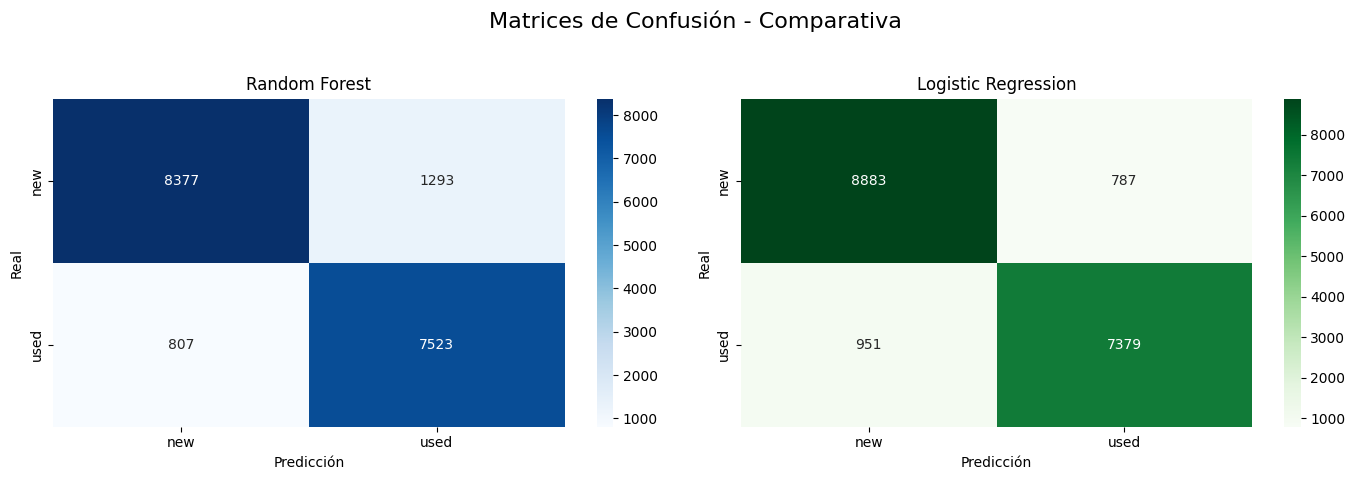

ROC AUC Score (Random Forest): 0.9537911338268502
ROC AUC Score (Logistic Regression): 0.9633904192493957


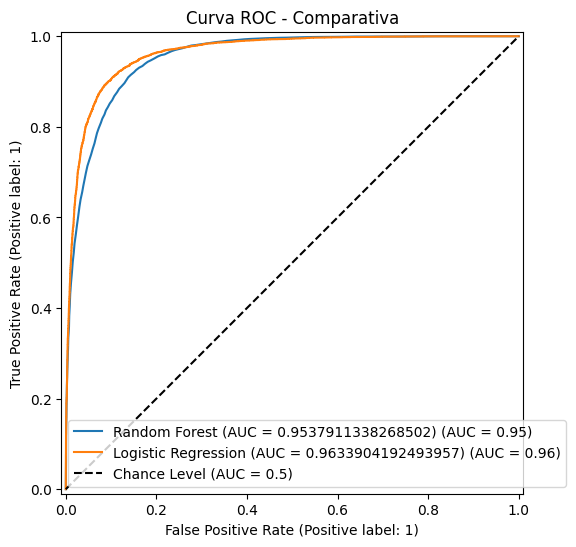


--- 5. EXPERIMENTO: Impacto de la cantidad de datos ---

 Entrenando con 20.0% de los datos (10800 muestras)...
    Accuracy: 0.8579 | ROC AUC: 0.9329

 Entrenando con 40.0% de los datos (21600 muestras)...
    Accuracy: 0.8678 | ROC AUC: 0.9397

 Entrenando con 60.0% de los datos (32400 muestras)...
    Accuracy: 0.8736 | ROC AUC: 0.9478

 Entrenando con 80.0% de los datos (43200 muestras)...
    Accuracy: 0.8814 | ROC AUC: 0.9516

 Entrenando con 100.0% de los datos (54000 muestras)...
    Accuracy: 0.8833 | ROC AUC: 0.9538


¡EXPERIMENTOS COMPLETADOS!


In [ ]:
# ==============================================================================
# IMPORTS NECESARIOS (Agregamos MLflow)
# ==============================================================================

# ==============================================================================
# CONFIGURACIÓN DE MLFLOW 
# ==============================================================================

mlflow.set_tracking_uri("mlruns")  # Carpeta donde se guardan los experimentos
mlflow.set_experiment("Prediccion_New_vs_Used")  # Nombre del experimento

print(" MLflow - Experimento: 'Prediccion_New_vs_Used'\n")


# ==============================================================================
# 0. DATA PREPARATION 
# ==============================================================================
y_original = y.copy()  # Variable objetivo original 
X_final_features = X[final_feature_list]  # Selección final de características

# a. Codificar la variable objetivo 'y' de texto a números (0 y 1)
le = LabelEncoder()
y_final = le.fit_transform(y_original)

y_original = y  # Variable objetivo original (texto)
X_final_features = X[final_feature_list]  # Selección final de características
class_labels = ["new","used"]

# b. Dividir los datos en entrenamiento y prueba (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_final_features, y_final, test_size=0.2, random_state=42, stratify=y_final
)

#  APLICA LA LIMPIEZA A LOS DATASETS COMPLETOS ANTES DE CONTINUAR ---
print("--- Limpiando tipos de datos en los sets completos ---")
categorical_features_to_fix = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_features_to_fix:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("¡Limpieza completada!")

# Ahora, crea el set de validación a partir de los datos YA LIMPIOS
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del set de validación: {X_val.shape[0]}")
print(f"Tamaño del set de prueba: {X_test.shape[0]}")
print("\n")

# ==============================================================================
# GUARDAR INFO DE DATOS EN MLFLOW 
# ==============================================================================
# Creamos un diccionario con información sobre los datos
data_info = {
    "total_samples": len(X_final_features),
    "train_samples": X_train.shape[0],
    "val_samples": X_val.shape[0],
    "test_samples": X_test.shape[0],
    "num_features": X_final_features.shape[1],
    "train_percentage": 0.6,  # 60% del total (80% * 75%)
    "val_percentage": 0.2,    # 20% del total (80% * 25%)
    "test_percentage": 0.2     # 20% del total
}

# ==============================================================================
# 1. PREPROCESSING PIPELINE 
# ==============================================================================
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert all categorical columns to string to avoid mixed type errors
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# ==============================================================================
# 2. CROSS-VALIDATION con MLFLOW 
# ==============================================================================
print("--- 2. Realizando Cross-Validation para Random Forest con MLflow ---")

# Iniciamos un run de MLflow para Random Forest con CV
with mlflow.start_run(run_name="RandomForest_CrossValidation"):
    
    # Hiperparámetros del modelo
    rf_params = {
        "n_estimators": 100,
        "random_state": 42,
        "n_jobs": -1,
        "model_type": "RandomForest"
    }
    
    # Registrar hiperparámetros en MLflow
    mlflow.log_params(rf_params)
    
    # Registrar información de los datos
    mlflow.log_params(data_info)
    
    # Create the full pipeline with the RandomForest model
    rf_pipeline = make_pipeline(preprocessor, RandomForestClassifier(
        n_estimators=rf_params["n_estimators"],
        random_state=rf_params["random_state"],
        n_jobs=rf_params["n_jobs"]
    ))
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Registrar métricas de CV en MLflow
    mlflow.log_metric("cv_roc_auc_mean", cv_scores.mean())
    mlflow.log_metric("cv_roc_auc_std", cv_scores.std())
    
    # Registrar cada fold individual
    for i, score in enumerate(cv_scores):
        mlflow.log_metric(f"cv_fold_{i+1}_roc_auc", score)
    
    print(f"Puntajes ROC AUC de Cross-Validation: {np.round(cv_scores, 4)}")
    print(f"Promedio de ROC AUC en CV: {cv_scores.mean()} (+/- {cv_scores.std()})")
    print(" Métricas de CV guardadas en MLflow")



# ==============================================================================
# 3. MODEL TRAINING AND COMPARISON con MLFLOW 
# ==============================================================================
print("--- 3. Entrenando y Comparando Modelos con MLflow ---")

# a. RANDOM FOREST con MLflow
print("\n Entrenando RandomForest con MLflow...")
with mlflow.start_run(run_name="RandomForest_Final"):
    
    # Hiperparámetros
    rf_params = {
        "n_estimators": 100,
        "max_depth": None,  # Puedes agregar más hiperparámetros
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42,
        "model_type": "RandomForest"
    }
    
    # Registrar hiperparámetros
    mlflow.log_params(rf_params)
    mlflow.log_params(data_info)
    
    # Entrenar modelo
    rf_pipeline = make_pipeline(preprocessor, RandomForestClassifier(**{k: v for k, v in rf_params.items() if k != 'model_type'}))
    rf_pipeline.fit(X_train, y_train)
    
    # Predicciones en validación
    y_val_pred_rf = rf_pipeline.predict(X_val)
    y_val_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]
    
    # Predicciones en test
    y_pred_rf = rf_pipeline.predict(X_test)
    y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Métricas en validación
    val_accuracy = accuracy_score(y_val, y_val_pred_rf)
    val_precision = precision_score(y_val, y_val_pred_rf)
    val_recall = recall_score(y_val, y_val_pred_rf)
    val_f1 = f1_score(y_val, y_val_pred_rf)
    val_roc_auc = roc_auc_score(y_val, y_val_proba_rf)
    
    # Métricas en test
    test_accuracy = accuracy_score(y_test, y_pred_rf)
    test_precision = precision_score(y_test, y_pred_rf)
    test_recall = recall_score(y_test, y_pred_rf)
    test_f1 = f1_score(y_test, y_pred_rf)
    test_roc_auc = roc_auc_score(y_test, y_proba_rf)
    
    # Registrar métricas en MLflow
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)
    
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)
    
    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(rf_pipeline, "random_forest_model")
    
    # Guardar matriz de confusión como imagen
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('Random Forest - Matriz de Confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    plt.tight_layout()
    
    # Guardar la figura en MLflow
    mlflow.log_figure(fig, "confusion_matrix_rf.png")
    plt.close()
    
    print(f" Random Forest - Test ROC AUC: {test_roc_auc}")
    print(f"   Accuracy: {test_accuracy} | Precision: {test_precision} | Recall: {test_recall}")

# b. LOGISTIC REGRESSION con MLflow
print("\n Entrenando Logistic Regression con MLflow...")
with mlflow.start_run(run_name="LogisticRegression_Final"):
    
    # Hiperparámetros
    lr_params = {
        "C": 1.0,  # Regularización
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 1000,
        "random_state": 42,
        "model_type": "LogisticRegression"
    }
    
    # Registrar hiperparámetros
    mlflow.log_params(lr_params)
    mlflow.log_params(data_info)
    
    # Entrenar modelo
    lr_pipeline = make_pipeline(preprocessor, LogisticRegression(
        C=lr_params["C"],
        penalty=lr_params["penalty"],
        solver=lr_params["solver"],
        max_iter=lr_params["max_iter"],
        random_state=lr_params["random_state"]
    ))
    lr_pipeline.fit(X_train, y_train)
    
    # Predicciones en validación
    y_val_pred_lr = lr_pipeline.predict(X_val)
    y_val_proba_lr = lr_pipeline.predict_proba(X_val)[:, 1]
    
    # Predicciones en test
    y_pred_lr = lr_pipeline.predict(X_test)
    y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
    
    # Calcular métricas en validación
    val_accuracy = accuracy_score(y_val, y_val_pred_lr)
    val_precision = precision_score(y_val, y_val_pred_lr)
    val_recall = recall_score(y_val, y_val_pred_lr)
    val_f1 = f1_score(y_val, y_val_pred_lr)
    val_roc_auc = roc_auc_score(y_val, y_val_proba_lr)
    
    # Calcular métricas en test
    test_accuracy = accuracy_score(y_test, y_pred_lr)
    test_precision = precision_score(y_test, y_pred_lr)
    test_recall = recall_score(y_test, y_pred_lr)
    test_f1 = f1_score(y_test, y_pred_lr)
    test_roc_auc = roc_auc_score(y_test, y_proba_lr)
    
    # Registrar métricas en MLflow
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)
    
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)
    
    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(lr_pipeline, "logistic_regression_model")
    
    # Guardar matriz de confusión como imagen
    cm_lr = confusion_matrix(y_test, y_pred_lr)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('Logistic Regression - Matriz de Confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    plt.tight_layout()
    
    # Guardar la figura en MLflow
    mlflow.log_figure(fig, "confusion_matrix_lr.png")
    plt.close()
    
    print(f" Logistic Regression - Test ROC AUC: {test_roc_auc}")
    print(f"   Accuracy: {test_accuracy} | Precision: {test_precision} | Recall: {test_recall}")

print("\n¡Modelos entrenados y registrados en MLflow!")


# ==============================================================================
# 4. EVALUATION ON THE TEST SET 
# ==============================================================================
print("--- 4. Evaluación Final en el Set de Prueba ---")

# --- Classification Reports ---
print("\n### Reporte de Clasificación - RandomForest ###")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))

print("\n### Reporte de Clasificación - Logistic Regression ###")
print(classification_report(y_test, y_pred_lr, target_names=class_labels))

# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión - Comparativa', fontsize=16)

# RandomForest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_title('Random Forest')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Calculate AUC scores (ya calculados arriba, pero los mostramos de nuevo)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"ROC AUC Score (Random Forest): {roc_auc_rf}")
print(f"ROC AUC Score (Logistic Regression): {roc_auc_lr}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name=f'Random Forest (AUC = {roc_auc_rf})', ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name=f'Logistic Regression (AUC = {roc_auc_lr})', ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
ax.set_title('Curva ROC - Comparativa')
ax.legend()
plt.show()

# ==============================================================================
# EXPERIMENTO ADICIONAL: VARIANDO CANTIDAD DE DATOS (NUEVO)
# ==============================================================================

print("\n--- 5. EXPERIMENTO: Impacto de la cantidad de datos ---")

# Probaremos con diferentes porcentajes de datos de entrenamiento
data_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

for percentage in data_percentages:
    # Calcular cuántas muestras usar
    n_samples = int(len(X_train) * percentage)
    
    # Tomar un subset de los datos
    X_train_subset = X_train.iloc[:n_samples]
    y_train_subset = y_train[:n_samples]
    
    print(f"\n Entrenando con {percentage*100}% de los datos ({n_samples} muestras)...")
    
    # Run de MLflow para este experimento
    with mlflow.start_run(run_name=f"RF_DataSize_{percentage*100:.0f}%"):
        
        # Registrar hiperparámetros
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("data_percentage", percentage)
        mlflow.log_param("train_samples_used", n_samples)
        mlflow.log_param("total_train_samples", len(X_train))
        
        # Entrenar modelo con subset de datos
        rf_subset = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100, random_state=42))
        rf_subset.fit(X_train_subset, y_train_subset)
        
        # Evaluar en test set
        y_pred_subset = rf_subset.predict(X_test)
        y_proba_subset = rf_subset.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred_subset)
        roc_auc = roc_auc_score(y_test, y_proba_subset)
        
        # Registrar métricas
        mlflow.log_metric("test_accuracy", accuracy)
        mlflow.log_metric("test_roc_auc", roc_auc)
        
        print(f"    Accuracy: {accuracy:.4f} | ROC AUC: {roc_auc:.4f}")

print("\n" )
print("¡EXPERIMENTOS COMPLETADOS!")


# Analizar datos y contenido en forma logica para filtrar el contenido de 50 variables mejor explicarían el modelo

In [24]:
X["seller_address_id"].value_counts()

seller_address_id
151514457    850
67672808     654
80972013     424
103278201    408
122665977    318
            ... 
56232799       1
140481671      1
156295625      1
87577051       1
166930169      1
Name: count, Length: 33289, dtype: int64

In [28]:
analyzed_feature_list = final_feature_list[:50]
analyzed_feature_list.remove("pictures_0_id")
analyzed_feature_list.remove("id")
analyzed_feature_list.remove("parent_item_id")
analyzed_feature_list.remove("seller_address_id")


 MLflow guardará los experimentos en: /Users/johnorozcogiraldo/CODE/Mercadolibre/mlruns
 Usando experimento existente 'Prediccion_New_vs_Used_2' con ID: 163902603394835360
--- Limpiando tipos de datos en los sets completos ---
¡Limpieza completada!
Tamaño del set de entrenamiento: 54000
Tamaño del set de validación: 18000
Tamaño del set de prueba: 18000
------------------------------------------------------------

 ENTRENANDO RANDOM FOREST CON MLFLOW...
 Run ID: e3bda2a9dbfb4692b50d358c618ca0cd
   Entrenando modelo...


2025/09/01 11:51:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


    Accuracy: 0.8846
    Precision (new): 0.9156 <- MÉTRICA SECUNDARIA CLAVE
    ROC AUC: 0.9560
   Guardando modelo...


2025/09/01 11:51:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForest_NewVsUsed' already exists. Creating a new version of this model...
Created version '4' of model 'RandomForest_NewVsUsed'.


   Generando matriz de confusión...
    Run completado: e3bda2a9dbfb4692b50d358c618ca0cd

 ENTRENANDO LOGISTIC REGRESSION CON MLFLOW...
 Run ID: 33021275e4974bbf95f0618bc1708164
   Entrenando modelo...


2025/09/01 11:51:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


    Accuracy: 0.8977
    Precision (new): 0.8999 <- MÉTRICA SECUNDARIA CLAVE
    ROC AUC: 0.9603
   Guardando modelo...


2025/09/01 11:51:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_NewVsUsed' already exists. Creating a new version of this model...
Created version '4' of model 'LogisticRegression_NewVsUsed'.


   Generando matriz de confusión...
    Run completado: 33021275e4974bbf95f0618bc1708164

 EXPERIMENTO: Impacto de la cantidad de datos

Entrenando con 30% de los datos (16200 muestras)...
    Accuracy: 0.8656 | Precision: 0.8966

Entrenando con 60% de los datos (32400 muestras)...
    Accuracy: 0.8771 | Precision: 0.9032

Entrenando con 100% de los datos (54000 muestras)...
    Accuracy: 0.8846 | Precision: 0.9114

 GENERANDO REPORTES FINALES

### Reporte de Clasificación - RandomForest ###
              precision    recall  f1-score   support

         new       0.92      0.86      0.89      9670
        used       0.85      0.91      0.88      8330

    accuracy                           0.88     18000
   macro avg       0.88      0.89      0.88     18000
weighted avg       0.89      0.88      0.88     18000


### Reporte de Clasificación - Logistic Regression ###
              precision    recall  f1-score   support

         new       0.90      0.91      0.91      9670
        use

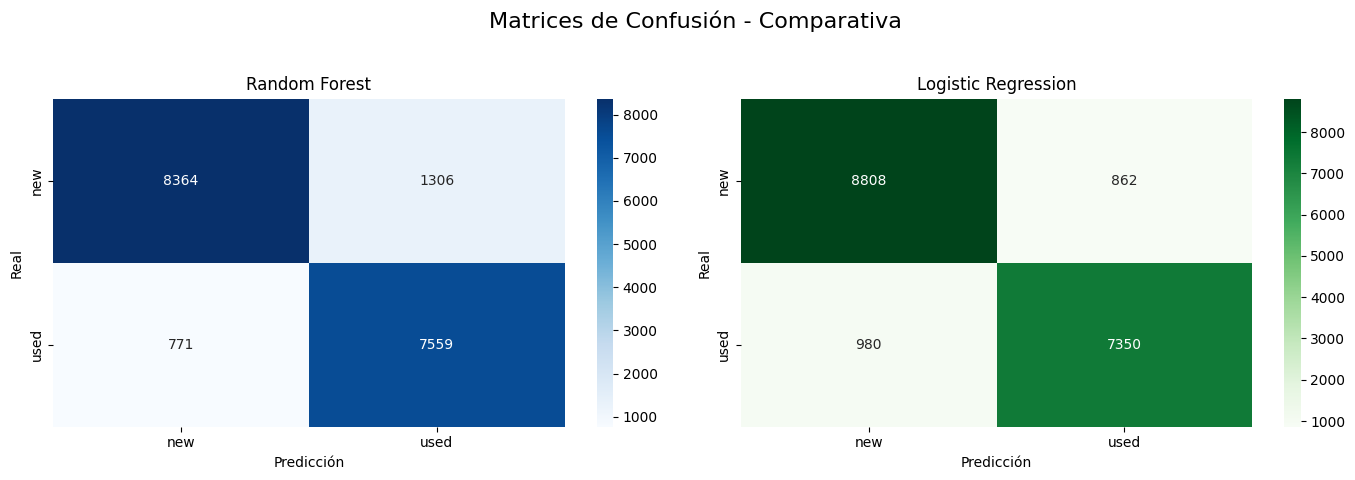


 MÉTRICAS FINALES:
ROC AUC Score (Random Forest): 0.9560
ROC AUC Score (Logistic Regression): 0.9603


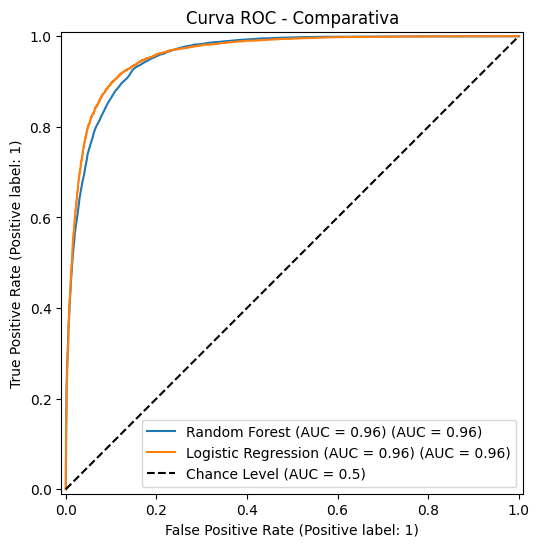


 DIAGNÓSTICO DE MLFLOW
 Experimento encontrado: Prediccion_New_vs_Used_2
   ID: 163902603394835360
   Ubicación: file:////Users/johnorozcogiraldo/CODE/Mercadolibre/mlruns/163902603394835360

 Runs encontrados: 10
   1. RF_DataSize_100pct - Status: FINISHED
      Accuracy: 0.8845555555555555
      Precision: 0.9114459137220897
   2. RF_DataSize_60pct - Status: FINISHED
      Accuracy: 0.8770555555555556
      Precision: 0.9032118524927003
   3. RF_DataSize_30pct - Status: FINISHED
      Accuracy: 0.8656111111111111
      Precision: 0.8966196258615031
   4. LogisticRegression_Model - Status: FINISHED
      Accuracy: 0.8976666666666666
      Precision: 0.8998774008990601
   5. RandomForest_Model - Status: FINISHED
      Accuracy: 0.8846111111111111
      Precision: 0.91559934318555


In [ ]:
# ==============================================================================
# NUEVO TRAINING DETALLADO Y GUARDADO EN MLFLOW
# ==============================================================================


mlflow_dir = os.path.join(os.getcwd(), "mlruns")
print(f" MLflow guardará los experimentos en: {mlflow_dir}")

mlflow.set_tracking_uri(f"file:///{mlflow_dir}")

# Crear o configurar el experimento
experiment_name = "Prediccion_New_vs_Used_2"
try:
    # Intentar crear el experimento
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f" Experimento '{experiment_name}' creado con ID: {experiment_id}")
except:
    # Si ya existe, obtener su ID
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        experiment_id = experiment.experiment_id
        print(f" Usando experimento existente '{experiment_name}' con ID: {experiment_id}")
    else:
        # Si no existe y no se pudo crear, usar default
        experiment_id = "0"
        print(f" Usando experimento default con ID: {experiment_id}")

# Establecer el experimento activo
mlflow.set_experiment(experiment_name)



# ==============================================================================
# 0. DATA PREPARATION (Asumiendo que X_final_features y y_original están cargados)
# ==============================================================================


y_original = y.copy()  # Variable objetivo original (texto)
X_final_features = X[analyzed_feature_list]  # Selección final de características

# a. Codificar la variable objetivo 'y' de texto a números (0 y 1)
le = LabelEncoder()
y_final = le.fit_transform(y_original)

class_labels = ["new", "used"]

# b. Dividir los datos en entrenamiento y prueba (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_final_features, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# Limpieza de datos
print("--- Limpiando tipos de datos en los sets completos ---")
categorical_features_to_fix = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_features_to_fix:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("¡Limpieza completada!")

# Crear set de validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del set de validación: {X_val.shape[0]}")
print(f"Tamaño del set de prueba: {X_test.shape[0]}")

# Información de los datos
data_info = {
    "total_samples": len(X_final_features),
    "train_samples": X_train.shape[0],
    "val_samples": X_val.shape[0],
    "test_samples": X_test.shape[0],
    "num_features": X_final_features.shape[1],
}

# ==============================================================================
# 1. PREPROCESSING PIPELINE 
# ==============================================================================
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert categorical columns to string
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# ==============================================================================
# 2. RANDOM FOREST - ENTRENAMIENTO PRINCIPAL
# ==============================================================================
print("\n ENTRENANDO RANDOM FOREST CON MLFLOW...")

mlflow.end_run()

# Iniciar un nuevo run con nombre descriptivo
with mlflow.start_run(run_name="RandomForest_Model", experiment_id=experiment_id) as run:
    
    print(f" Run ID: {run.info.run_id}")
    
    # Hiperparámetros
    rf_params = {
        "model_type": "RandomForest",
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42
    }
    
    # Registrar hiperparámetros uno por uno 
    for param_name, param_value in rf_params.items():
        mlflow.log_param(param_name, param_value)
    
    # Registrar info de datos
    for data_name, data_value in data_info.items():
        mlflow.log_param(data_name, data_value)
    
    # Entrenar modelo
    print("   Entrenando modelo...")
    rf_model = RandomForestClassifier(
        n_estimators=rf_params["n_estimators"],
        max_depth=rf_params["max_depth"],
        min_samples_split=rf_params["min_samples_split"],
        min_samples_leaf=rf_params["min_samples_leaf"],
        random_state=rf_params["random_state"],
        n_jobs=-1
    )
    
    rf_pipeline = make_pipeline(preprocessor, rf_model)
    rf_pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred_rf = rf_pipeline.predict(X_test)
    y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    test_accuracy = accuracy_score(y_test, y_pred_rf)
    test_precision = precision_score(y_test, y_pred_rf, pos_label=0)  
    test_recall = recall_score(y_test, y_pred_rf)
    test_f1 = f1_score(y_test, y_pred_rf)
    test_roc_auc = roc_auc_score(y_test, y_proba_rf)
    
    # IMPORTANTE: Registrar métricas una por una
    mlflow.log_metric("accuracy", test_accuracy)
    mlflow.log_metric("precision_new_class", test_precision)  
    mlflow.log_metric("recall", test_recall)
    mlflow.log_metric("f1_score", test_f1)
    mlflow.log_metric("roc_auc", test_roc_auc)
    
    print(f"    Accuracy: {test_accuracy:.4f}")
    print(f"    Precision (new): {test_precision:.4f} <- MÉTRICA SECUNDARIA CLAVE")
    print(f"    ROC AUC: {test_roc_auc:.4f}")
    
    # Guardar modelo
    print("   Guardando modelo...")
    mlflow.sklearn.log_model(
        sk_model=rf_pipeline,
        artifact_path="model",
        registered_model_name="RandomForest_NewVsUsed"
    )
    
    # Crear y guardar matriz de confusión
    print("   Generando matriz de confusión...")
    cm = confusion_matrix(y_test, y_pred_rf)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('Random Forest - Matriz de Confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    plt.tight_layout()
    
    # Guardar figura
    mlflow.log_figure(fig, "confusion_matrix.png")
    plt.savefig("rf_confusion_matrix_local.png")  
    plt.close()
    

    with open("rf_metrics.txt", "w") as f:
        f.write(f"Accuracy: {test_accuracy:.4f}\n")
        f.write(f"Precision (new): {test_precision:.4f}\n")
        f.write(f"Recall: {test_recall:.4f}\n")
        f.write(f"F1-Score: {test_f1:.4f}\n")
        f.write(f"ROC AUC: {test_roc_auc:.4f}\n")
    
    mlflow.log_artifact("rf_metrics.txt")
    
    print(f"    Run completado: {run.info.run_id}")

# ==============================================================================
# 3. LOGISTIC REGRESSION - ENTRENAMIENTO
# ==============================================================================
print("\n ENTRENANDO LOGISTIC REGRESSION CON MLFLOW...")

# Terminar cualquier run activo
mlflow.end_run()

with mlflow.start_run(run_name="LogisticRegression_Model", experiment_id=experiment_id) as run:
    
    print(f" Run ID: {run.info.run_id}")
    
    # Hiperparámetros
    lr_params = {
        "model_type": "LogisticRegression",
        "C": 1.0,
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 1000,
        "random_state": 42
    }
    
    # Registrar hiperparámetros
    for param_name, param_value in lr_params.items():
        mlflow.log_param(param_name, param_value)
    
    # Registrar info de datos
    for data_name, data_value in data_info.items():
        mlflow.log_param(data_name, data_value)
    
    # Entrenar modelo
    print("   Entrenando modelo...")
    lr_model = LogisticRegression(
        C=lr_params["C"],
        penalty=lr_params["penalty"],
        solver=lr_params["solver"],
        max_iter=lr_params["max_iter"],
        random_state=lr_params["random_state"]
    )
    
    lr_pipeline = make_pipeline(preprocessor, lr_model)
    lr_pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred_lr = lr_pipeline.predict(X_test)
    y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    test_accuracy = accuracy_score(y_test, y_pred_lr)
    test_precision = precision_score(y_test, y_pred_lr, pos_label=0)  
    test_recall = recall_score(y_test, y_pred_lr)
    test_f1 = f1_score(y_test, y_pred_lr)
    test_roc_auc = roc_auc_score(y_test, y_proba_lr)
    
    # Registrar métricas
    mlflow.log_metric("accuracy", test_accuracy)
    mlflow.log_metric("precision_new_class", test_precision)  
    mlflow.log_metric("recall", test_recall)
    mlflow.log_metric("f1_score", test_f1)
    mlflow.log_metric("roc_auc", test_roc_auc)
    
    print(f"    Accuracy: {test_accuracy:.4f}")
    print(f"    Precision (new): {test_precision:.4f} <- MÉTRICA SECUNDARIA CLAVE")
    print(f"    ROC AUC: {test_roc_auc:.4f}")
    
    # Guardar modelo
    print("   Guardando modelo...")
    mlflow.sklearn.log_model(
        sk_model=lr_pipeline,
        artifact_path="model",
        registered_model_name="LogisticRegression_NewVsUsed"
    )
    
    # Crear y guardar matriz de confusión
    print("   Generando matriz de confusión...")
    cm = confusion_matrix(y_test, y_pred_lr)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('Logistic Regression - Matriz de Confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    plt.tight_layout()
    
    # Guardar figura
    mlflow.log_figure(fig, "confusion_matrix.png")
    plt.savefig("lr_confusion_matrix_local.png")  # También guardar localmente
    plt.close()
    
    print(f"    Run completado: {run.info.run_id}")

# ==============================================================================
# 4. EXPERIMENTO: VARIANDO CANTIDAD DE DATOS
# ==============================================================================
print("\n EXPERIMENTO: Impacto de la cantidad de datos")


data_percentages = [0.3, 0.6, 1.0]  # Reducido para prueba rápida

for percentage in data_percentages:
    n_samples = int(len(X_train) * percentage)
    
    print(f"\nEntrenando con {percentage*100:.0f}% de los datos ({n_samples} muestras)...")
    
    # Terminar cualquier run activo
    mlflow.end_run()
    
    with mlflow.start_run(run_name=f"RF_DataSize_{percentage*100:.0f}pct", experiment_id=experiment_id):
        
        # Parámetros del experimento
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_param("data_percentage", percentage)
        mlflow.log_param("samples_used", n_samples)
        
        # Subset de datos
        X_train_subset = X_train.iloc[:n_samples]
        y_train_subset = y_train[:n_samples]
        
        # Entrenar
        rf_subset = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=50, random_state=42))
        rf_subset.fit(X_train_subset, y_train_subset)
        
        # Evaluar
        y_pred = rf_subset.predict(X_test)
        y_proba = rf_subset.predict_proba(X_test)[:, 1]
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=0)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Registrar
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision_new_class", precision)
        mlflow.log_metric("roc_auc", roc_auc)
        
        print(f"    Accuracy: {accuracy:.4f} | Precision: {precision:.4f}")

# ==============================================================================
# VISUALIZACIONES FINALES 
# ==============================================================================
print("\n GENERANDO REPORTES FINALES")

# Classification Reports
print("\n### Reporte de Clasificación - RandomForest ###")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))

print("\n### Reporte de Clasificación - Logistic Regression ###")
print(classification_report(y_test, y_pred_lr, target_names=class_labels))

# Comparativa de matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión - Comparativa', fontsize=16)

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_title('Random Forest')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ROC Curves
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"\n MÉTRICAS FINALES:")
print(f"ROC AUC Score (Random Forest): {roc_auc_rf:.4f}")
print(f"ROC AUC Score (Logistic Regression): {roc_auc_lr:.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_proba_rf, 
                                name=f'Random Forest (AUC = {roc_auc_rf:.2f})', ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr, 
                                name=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
ax.set_title('Curva ROC - Comparativa')
ax.legend()
plt.show()

# ==============================================================================
# VERIFICACIÓN FINAL Y DIAGNÓSTICO
# ==============================================================================
print("\n DIAGNÓSTICO DE MLFLOW")

# Verificar que los experimentos se guardaron
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment:
    print(f" Experimento encontrado: {experiment.name}")
    print(f"   ID: {experiment.experiment_id}")
    print(f"   Ubicación: {experiment.artifact_location}")
    
    # Buscar runs en el experimento
    from mlflow.tracking import MlflowClient
    client = MlflowClient()
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])
    
    print(f"\n Runs encontrados: {len(runs)}")
    for i, run in enumerate(runs[:5]):  # Mostrar máximo 5
        print(f"   {i+1}. {run.info.run_name} - Status: {run.info.status}")
        print(f"      Accuracy: {run.data.metrics.get('accuracy', 'N/A')}")
        print(f"      Precision: {run.data.metrics.get('precision_new_class', 'N/A')}")
else:
    print(" No se encontró el experimento")

